# Report on BG CV test task

## Artyom V. Vasiliev

#### this notebook has the following structure:

* [0. Problem description](#description)
* [1.0. CNN Image classifier](#image-classifier)
* [1.1. - Data overview](#image-classifier-data-overview)
* [1.2. - Data preprocessing](#image-classifier-data-preprocessing)
* [1.3. - Transfer Learning approach](#image-classifier-transfer-learning)
* [1.4. - CNN results](#image-classifier-results)
* [2.0. KNN classifier](#KNN-classifier)
* [2.1. - Random synthetic dataset for classification points in $\mathbb{R}^m$](#KNN-dataset)
* [2.2. - naive python KNN implementation](#KNN-python-class)
* [2.3. - KNN results](#KNN-classifier-results)

## 0. Problem description <a class="anchor" id="description"></a>

**Problem 1:**
> Используя фреймворк pytorch, реализуйте архитектуру для
классификации изображений по стилям художников. Для решения задачи можно
взять достаточно простые архитектуры.
Изображения для обучения необходимо уменьшить до размера 64x64 или
128x128 (при наличии ресурсов). Обучить реализованную модель на
предобработанном датасете. Нарисовать графики изменения значений лосса и
выбранных метрик по эпохам.
Результаты представить в Jupyter ноутбуке.

**Problem 1 extras:** 
> Вместо выхода сети-классификатора используйте одномерный вектор с
предпоследнего слоя сети. Используя этот вектор, как набор признаков для каждого
изображения, попробуйте кластеризовать получившийся датасет векторов любым
подходящим (по вашему мнению) алгоритмом. Попробуйте определить, по каким
признакам различаются полученные кластера.
Используя набор признаков, полученных в предыдущем пункте, примените
XGBoost для решения задачи классификации. Сравните метрики качества XGBoost
и нейронной сети.

**Problem 2:** 
> Необходимо реализовать алгоритм knn(k nearest neighbors) на python и c++ (по
возможности).
Минимальный прототип:
```python
def knn(points, k=10)
```
> При необходимости аргументы можно добавлять.
points - матрица размера NxM, где N - количество точек, M-размерность
пространства. В качестве выхода матрица Nxk с индексами ближайших k соседей,
отсортированных по L2 расстоянию. Для теста использовать рандомно
сгенерированные точки. Программа должна работать для значений N, M и k порядка
10^4, 20, 30 соответственно.

**Problem 2 extras:** 
> Добавить в функцию аргумент metric, с помощью которого можно выбирать способ
вычисления расстояния. Реализовать подобный алгоритм для L1 и cosine distance.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, os.path
import sys
import copy
import time
import subprocess

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder

In [2]:
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torchvision.__version__)
print('Using device:', device)
device = torch.device("cpu")

1.7.0a0+e85d494
0.8.0a0+291f7e2
Using device: cuda:0


## 1.0. CNN Image classifier <a class="anchor" id="image-classifier"></a>

Objective to design CNN image classifier is seems to be a common knowledge in a field of CV science. I will refer [the Stanford CS 231n class notes](https://cs231n.github.io/ "CS231n: Convolutional Neural Networks for Visual Recognition") and [tutorial in PyTorch documentation](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#transfer-learning-for-computer-vision-tutorial "TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL") for my report.

### 1.1. - Data overview <a class="anchor" id="image-classifier-data-overview"></a> 

Before anything else, let's start from unzipping raw data. File `images_full.zip` should be placed in project root directory.

In [3]:
bashCommand = "unzip images_full.zip"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
bashCommand = "ls images"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
classes = list(filter(None, output.decode("utf-8").split('\n')))
nclasses = len(classes)
print(nclasses, classes)

8 ['ArtDeco', 'cartoon', 'Cubism', 'Impressionism', 'Japonism', 'Naturalism', 'photo', 'Rococo']


One could easily find that images in the given dataset belongs to one of the $8$ different classes. Let's define the available number of samples in each of the classes:

In [4]:
per_class_names = {}
per_class_counts = {}

for cur_class in classes:
    DIR = 'images/{}'.format(cur_class)
    per_class_names[cur_class] = [name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]
    per_class_counts[cur_class] = len(per_class_names[cur_class])

overall_count = sum(per_class_counts.values())
print(overall_count)
per_class_counts

1422


{'ArtDeco': 65,
 'cartoon': 75,
 'Cubism': 365,
 'Impressionism': 240,
 'Japonism': 203,
 'Naturalism': 218,
 'photo': 139,
 'Rococo': 117}

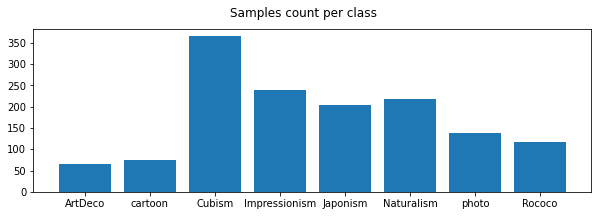

In [5]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(per_class_counts.keys(), per_class_counts.values())
fig.suptitle('Samples count per class')
plt.show()

So classes ArtDeco and cartoon; Impressionism, Japonisme and Naturism; photo and Rococo have about the same representation respectively. Class 'Cubism' is significantly more frequent than any others, while whole dataset is also class-imbalanced (but not dramatically hard).

Since we a not going to either perform mining extra samples for retarded classes (which I hope would be unnecessary according the framework of this test task) or use data augmentation to level imbalance (because of intuitive risk of overfitting on relatevly low ammount of unique samples), we will only use information about class-imbalance in order to choose train-validation-test split strategy. We want relative class frequencies to be approximately preserved in each train and validation data subset and so stratified sampling is about to perform in our solution.

It is also might be useful to study distribution of raw numerical data amount between different classes. As far as I am concerned, such quantity is associated with cumulative image area (in square pixels, since all images have same number of color channels) for a given class.

In [6]:
per_class_area = {}
for cur_class in classes:
    tmp_sum = 0
    for cur_img in per_class_names[cur_class]:
        DIR = 'images/{}/{}'.format(cur_class, cur_img)
        tmp_h, tmp_w, _ = cv2.imread(DIR).shape
        tmp_sum += tmp_h*tmp_w
    per_class_area[cur_class] = tmp_sum
per_class_area

{'ArtDeco': 12201886,
 'cartoon': 11240679,
 'Cubism': 69348818,
 'Impressionism': 44604509,
 'Japonism': 33894478,
 'Naturalism': 37954364,
 'photo': 24886364,
 'Rococo': 22172705}

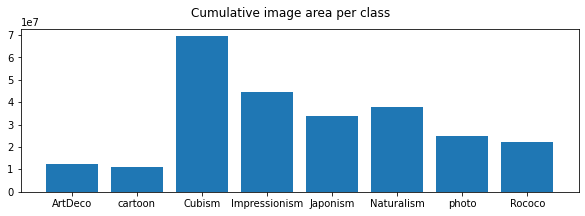

In [7]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(per_class_area.keys(), per_class_area.values())
fig.suptitle('Cumulative image area per class')
plt.show()

The resulting distribution of classes by area completely mirrors the distribution obtained above by count of class instances. Thus, we can conclude that the average area of the images for all classes does not differ significantly.

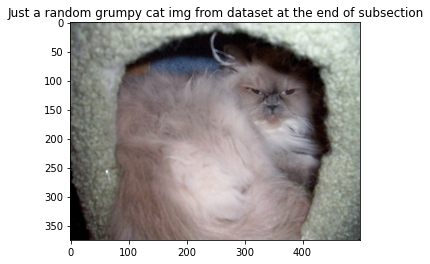

In [8]:
img = cv2.imread('images/photo/006512.jpg')[:,:,::-1]
plt.title('Just a random grumpy cat img from dataset at the end of subsection')
plt.imshow(img)
plt.show()

### 1.2. - Data preprocessing <a class="anchor" id="image-classifier-data-preprocessing"></a> 

In order to implement stratified test-train split approach it is natural to move all preprocessed files into a single directory and preapair `.csv` with image names and target class labels. Thus now we are going to use opencv to resize all images to $128\times 128$ pixels and save them in `dataset` directory. 

I will also want to utilize standard `OneHotEncoder` from` sklearn.preprocessing` to encode target labels. But it turned out to be unreasonably difficult for further work using standard PuTorch methods.

In [9]:
bashCommand = "rm -r dataset"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
os.mkdir('dataset')

enc = {currclass : x for x,currclass in enumerate(classes)}
deenc = {x : currclass for x,currclass in enumerate(classes)}

table_data = []
table_data.append(['id'] + ['label'])

for cur_class in classes:
    for cur_img_name in per_class_names[cur_class]:
        encoded_label = enc[cur_class]
        table_data.append([cur_img_name.replace('_', '-')] + [encoded_label])
        DIR = 'images/{}/{}'.format(cur_class, cur_img_name)
        OUTDIR = 'dataset/{}'.format(cur_img_name.replace('_', '-'))

        raw_img = cv2.imread(DIR)
        resized = cv2.resize(raw_img, (128, 128))
        cv2.imwrite(OUTDIR, resized)

column_names = table_data.pop(0)
df = pd.DataFrame(table_data, columns=column_names)
df.to_csv("dataset/labels.csv", index=False)

On the next step we will use `StratifiedKFold` from` sklearn.model_selection` to generate stratified train-test split in $ k = 4 $ folds.

In [10]:
fulldataset = pd.read_csv("dataset/labels.csv")

k=4

skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=False)
for fold_id, (train_index, test_index) in enumerate(skf.split(fulldataset['id'].tolist(), 
                                                              fulldataset['label'].tolist())):
    tmp_df_train = fulldataset.iloc[train_index]
    tmp_df_test = fulldataset.iloc[test_index]
    tmp_df_train.to_csv("dataset/train_fold{}.csv".format(fold_id), index=False)
    tmp_df_test.to_csv("dataset/test_fold{}.csv".format(fold_id), index=False)

Now we are about to prepare PyTorch wrapper for our data.

ref: [Dataset class tutorial in PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files "Creating a Custom Dataset for your files")

In [16]:
class ArtsImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_label_vectors = self.img_labels[['label']]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.classes = classes

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
#         image = cv2.imread(img_path)[:,:,::-1]
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1] #torch.tensor((self.img_label_vectors.iloc[idx]).to_list())
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets, dataloaders, dataset_sizes = [], [], []
for fold_id in range(0, k):
    image_datasets.append({x: ArtsImageDataset("dataset/{}_fold{}.csv".format(x, fold_id), 
                                               'dataset', transform=data_transforms[x])
                      for x in ['train', 'test']})
    dataloaders.append({x: torch.utils.data.DataLoader(image_datasets[fold_id][x], batch_size=64,
                                            shuffle=True, num_workers=4)
                  for x in ['train', 'test']})

    dataset_sizes.append({x: len(image_datasets[fold_id][x]) for x in ['train', 'test']})

class_names = image_datasets[0]['train'].classes
dataset_sizes

[{'train': 1066, 'test': 356},
 {'train': 1066, 'test': 356},
 {'train': 1067, 'test': 355},
 {'train': 1067, 'test': 355}]

['Cubism', 'Japonism', 'photo', 'Naturalism', 'Rococo', 'Japonism', 'Cubism', 'Japonism', 'Naturalism', 'Cubism', 'Cubism', 'cartoon', 'Naturalism', 'Impressionism', 'Naturalism', 'Cubism', 'Japonism', 'Rococo', 'photo', 'Rococo', 'Naturalism', 'Cubism', 'Impressionism', 'Naturalism', 'Impressionism', 'Japonism', 'Japonism', 'Cubism', 'Japonism', 'cartoon', 'Japonism', 'Cubism', 'Naturalism', 'photo', 'Cubism', 'Impressionism', 'Cubism', 'cartoon', 'ArtDeco', 'Japonism', 'Impressionism', 'Impressionism', 'Impressionism', 'Cubism', 'Japonism', 'Cubism', 'Naturalism', 'photo', 'Cubism', 'cartoon', 'ArtDeco', 'Cubism', 'Japonism', 'Naturalism', 'Impressionism', 'Cubism', 'Impressionism', 'Japonism', 'Japonism', 'Japonism', 'Japonism', 'Cubism', 'Cubism', 'Naturalism']


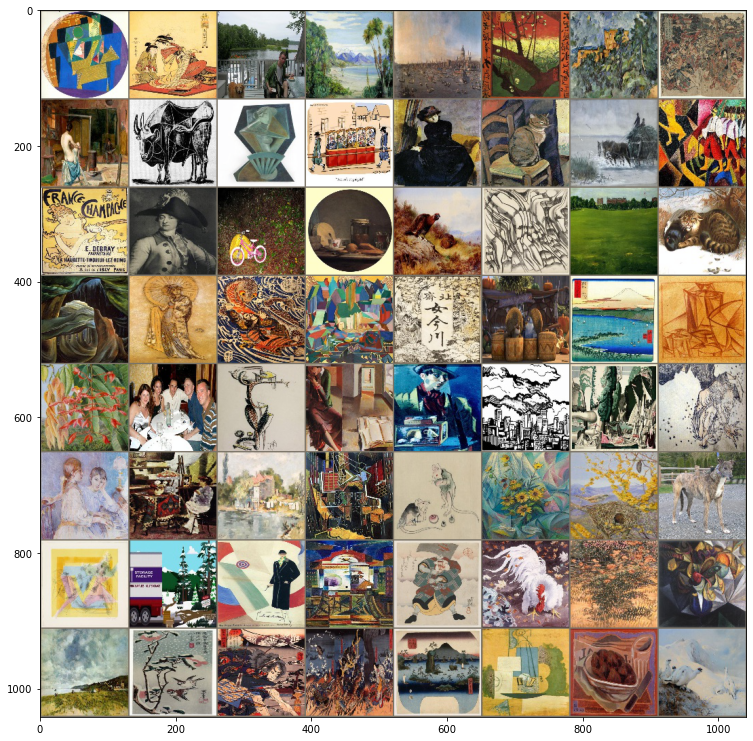

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig, ax = plt.subplots(figsize=(13, 13))
    ax.imshow(inp)
    if title is not None:
        print(title)


# Get a batch of training data
image_stream, labels_stream = next(iter(dataloaders[0]['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(image_stream)
imshow(out, title=[deenc[x] for x in labels_stream.numpy()])

### 1.3. - Transfer Learning approach <a class="anchor" id="image-classifier-transfer-learning"></a> 

In [20]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# redefine the last FC layer
model_ft.fc = nn.Linear(num_ftrs, nclasses)
model_ft = model_ft.to(device)

criterion = criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc



def train_model(model, criterion, optimizer, scheduler, num_epochs=25, fold_id=0):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[fold_id][phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = torch.log_softmax(model(inputs), dim = 1)
                    _, preds = torch.max(outputs, dim = 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                correct_pred = (preds == labels.data).float()
                running_corrects += correct_pred
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[0]['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = torch.log_softmax(model(inputs), dim = 1)
            _, preds = torch.max(outputs, dim = 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

        

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------


RuntimeError: The size of tensor a (64) must match the size of tensor b (42) at non-singleton dimension 0

## 1.4. - CNN results <a class="anchor" id="image-classifier-results"></a>

image-classifier-results

# 2.0. KNN classifier <a class="anchor" id="KNN-classifier"></a>

In this section we will discuss python implementation of $k$-nearest neighbors algorithm as non-parametric classification method. Firstly, we will develop configurable script for generating synthetic datasets with samples from two different multivariate Gaussian distributions. Secondly, we will implement python class for $k$-nearest neighbors classifier. Thirdly, we will measure our binary classifier performance on set of synthetic datasets with different macro-parameters such as number of point samples in $\mathbb{R}^m$ and dimension $m$.

The basic concept of $k$-nearest neighbors algorithm is pretty straightforward:

Consider $\{x_i\} \in \mathbb{R}^m$ to be $m$-dimensional representation of some objects from $n$ classes $\{{Class}_0 \dots {Class}_{n-1}\}$. The bijective correspondence between $\{x_i\}$ and $\{{Class}_0 \dots {Class}_{n-1}\}$ is assumed to be a priori known. We will call the $\{x_i\}$ a train dataset.

Consider $\{y_i\} \in \mathbb{R}^m$ for which actual class affiliation is unknown. In framework of $k$-nearest neighbors algorithm one could measure point-wise distance between given $y_j$ and each point in train dataset, pick $k$ nearest points and $y_j$ point by majority voting from set of labels of this neighbors.  

## 2.1. - Random synthetic dataset for classification points in $\mathbb{R}^m$ <a class="anchor" id="KNN-dataset"></a>

Use this script in order to generate synthetic dataset for binary classification problem:
```shell
cd knn
python datagenerator.py
cd -
```
Output dataset contain $n$ samples from two different multivariate Gaussian distributions with randomly chosen mean and covariance in $m$-dimensional space. Current script is configured to generate datasets for $n \in \{100, 15050, 30000\}$ and $m \in \{2, 11, 21, 30, 40\}$. One coud find them in `knn/data/nNSAMPLESmDIMfull.csv`. Script also splits full dataset into train and test in 4 folds: `knn/data/nNSAMPLESmDIMtrainFOLDID.csv` and `knn/data/nNSAMPLESmDIMtestFOLDID.csv`.

Most of `knn/data/*l.csv` is gitignored in order to keep this project repository clean.

Two-dimensional example:

In [ ]:
df = pd.read_csv("knn/data/n{}m{}train{}.csv".format(100, 2, 0))
train_data = df.to_numpy()[:,:-1]
train_target = df.to_numpy()[:,-1]
df = pd.read_csv("knn/data/n{}m{}test{}.csv".format(100, 2, 0))
test_data = df.to_numpy()[:,:-1]

cdict = {0: 'red', 1: 'blue'}
fig, ax = plt.subplots()
for g in np.unique(train_target):
    ix = np.where(train_target == g)
    ax.scatter(train_data[ix, 0], train_data[ix, 1], c = cdict[g], label = int(g), s = 100)
ax.scatter(test_data[:, 0], test_data[:, 1], c = 'black', label = 'test', s = 100, marker='x')
plt.axis('equal')
ax.legend()
plt.show()

## 2.2. - naive python KNN implementation <a class="anchor" id="KNN-python-class"></a>

From `knn/knn.py`:

```python
class KNN_Classifier:
    def __init__(self, train_points, train_labels, k=10, metric='euclidean'):
        self.train_points = train_points
        self.train_labels = train_labels
        self.k = k
        self.metric = metric
        self.N_train, self.M = train_points.shape


        
    def knn(self, test_points):
        N_test, M = test_points.shape
        pp_distance = np.full(N_test, np.inf)
        if self.metric == 'absolute':
            pp_distance = np.array([[np.sum(np.abs(x - y)) for y in self.train_points] for x in test_points])
        elif self.metric == 'cosine':
            dotroducts = np.array([[np.sum(x*y) for y in self.train_points] for x in test_points])
            inv_test_norms = 1.0 / np.sqrt(np.array([[np.sum(x*x) for y in self.train_points] for x in test_points]))
            inv_train_norms = 1.0 / np.sqrt(np.array([[np.sum(y*y) for y in self.train_points] for x in test_points]))
            pp_distance = dotroducts * inv_test_norms * inv_train_norms
        elif self.metric == 'euclidean':
            pp_distance = np.sqrt(np.array([[np.sum(np.square(x - y)) for y in self.train_points] for x in test_points]))
        else:
            print("Unknown metric.  The default Euclidean metric will be used.")
            pp_distance = np.sqrt(np.array([[np.sum(np.square(x - y)) for y in self.train_points] for x in test_points]))
        return np.argsort(pp_distance, axis=1)[:, 0:self.k]
    
    
    
    def classify(self, test_points):
        pred_labels = np.array([self.train_labels[x] for x in self.knn(test_points)], dtype=int)
        majority_vote = [np.argmax(np.bincount(x)) for x in pred_labels]
        return majority_vote
```

Example:

```python
# x_train in Ntrain*M matrix, y_train is Ntrain*1
# x is Ntest*M matrix
classifier = KNN_Classifier(x_train, y_train, metric='absolute')
y_pred = classifier.classify(x)
knearest = classifier.knn(x)
```

## 2.3. - KNN results <a class="anchor" id="KNN-classifier-results"></a>

Use 
```shell
cd knn
python knn.py
cd -
```
to evaluate knn on each dataset. We will also utilize standard `classification_report` from` sklearn.metrics` to measure classifier performance. One could find all reporst in `*.csv` files in `knn/results'.

In [ ]:
df = pd.read_csv("knn/data/n{}m{}train{}.csv".format(100, 2, 0))
train_data = df.to_numpy()[:,:-1]
train_target = df.to_numpy()[:,-1]
df = pd.read_csv("knn/results/n{}m{}pred{}.csv".format(100, 2, 0))
pred_data = df.to_numpy()[:,:-1]
pred_target = df.to_numpy()[:,-1]

cdict = {0: 'red', 1: 'blue'}
fig, ax = plt.subplots()
for g in np.unique(train_target):
    ix = np.where(train_target == g)
    ax.scatter(train_data[ix, 0], train_data[ix, 1], c = cdict[g], label = int(g), s = 50)

for g in np.unique(pred_target):
    ix = np.where(pred_target == g)
    ax.scatter(pred_data[ix, 0], pred_data[ix, 1], c = cdict[g], label = str(int(g))+' pred', s = 100, marker='x')
plt.axis('equal')
ax.legend()
plt.show()

Report example:

In [ ]:
df = pd.read_csv("knn/results/n{}m{}report{}.csv".format(100, 2, 0))
print(df)